In [1]:

import random
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
pd.options.display.max_colwidth = 1000
pd.options.mode.chained_assignment = None


##### Load Data

In [61]:
df = pd.read_excel('../data/men_activists/men_activists.xlsx')

##### Drop Null, Empty, and NaN values

In [62]:
df.dropna(subset=['text'], inplace=True) #remove nan value
df.drop_duplicates(subset=['text'], inplace=True) #remove nan duplicate value
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=1, how='all').loc[:, df.notna().any()]

##### Clean Data

In [63]:
def clean_tweet_text(text):
    # Check for null or NaN values
    if pd.isnull(text):
        return text
    # Remove URL
    text = re.sub(r'http\S+', '', text)
    
    # Remove RT (retweet) tag
    text = text.replace('RT', '')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove special characters and punctuations, and add a space after removing them
    text = re.sub(r'[^\w\s]', '', text)

    # Remove hashtags
    text = re.sub(r'#(\w+)', '', str(text))
    # Remove extra spaces
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    return text
# Apply the cleaning function to 'text' column
df['text'] = df['text'].apply(clean_tweet_text)


##### Remove Text Less then 30 characters

In [2]:
df = pd.read_excel('../data_processed/men_activists.xlsx')

In [3]:
df = df[df['text'].str.len() >=30]

##### Remove Empty Rows

In [4]:
def remove_empty_rows(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove rows with empty values in the column
        df = df[df[column].notna() & df[column].astype(str).str.strip().ne('')]
    return df

df = remove_empty_rows(df)


##### Remove All Null Values

In [5]:
def remove_null_columns(df):
    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Check if the column contains any null values
        if df[column].isnull().any():
            # If any null value exists, drop the column
            df = df.drop(column, axis=1)
    return df
df = remove_null_columns(df)


##### Remove Stopwords

In [6]:
from nltk.corpus import stopwords
def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df
df = remove_stopwords(df)

##### Convert Timezone

In [7]:
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date.astype(str)

##### Drop the whole rows which is >=2020

In [8]:
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d")
filtered_df = df[df["created_at"].dt.year >= 2020]
df.drop(df[df["created_at"].dt.year <= 2020].index, inplace=True)


##### Check How Many accounts are there

In [9]:
len(df['name'].unique())

54

##### Labeling Process

In [10]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str)

In [11]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment Analysis

In [12]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

##### Data Set Summary

In [13]:
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment Counts:\n", sentiment_counts)
total_counts = sentiment_counts['positive'] + sentiment_counts['negative']
print("Total Counts:", total_counts)

Sentiment Counts:
 sentiment
neutral     8307
positive    5180
negative    3913
Name: count, dtype: int64
Total Counts: 9093


##### Calculate positive tweets and percentage for women, single user

In [14]:
women_positive_count = df[(df['gender'] == 'male') & (df['sentiment'] == 'positive')].shape[0]
women_total_count = df[df['gender'] == 'male'].shape[0]
women_positive_percentage = (women_positive_count / women_total_count) * 100
# Print the results
print("Positive tweets from men:", women_positive_count, "(", women_positive_percentage, "%)")

Positive tweets from men: 5180 ( 29.770114942528735 %)


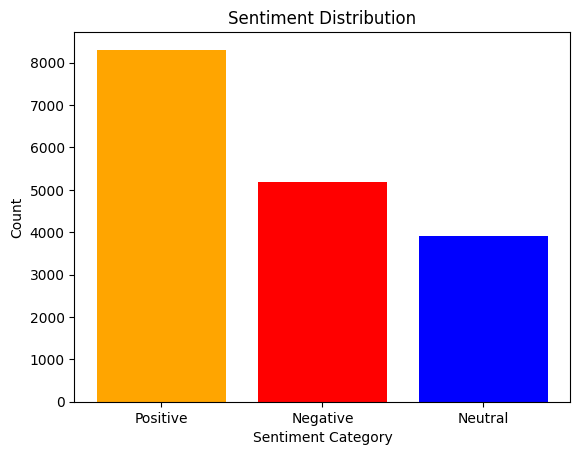

In [15]:
import matplotlib.pyplot as plt
# Bar chart
sentiment_categories = ['Positive', 'Negative', 'Neutral']
counts = df['sentiment'].value_counts()
colors = ['orange', 'red', 'blue']
plt.bar(sentiment_categories, counts, color=colors)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

##### Content Analysis

In [16]:
df_edu = df.loc[df['label'] == 1]
print("Number of tweets in favor of education: ", len(df_edu))

Number of tweets in favor of education:  6471


##### Code Schema

In [17]:
coding_scheme = {
'women': ['women', 'woman', 'female', 'feminine', 'girl', 'lady'],
'education': ['education', 'educational', 'learning', 'academics', 'knowledge'],
'school': ['school', 'classroom', 'teacher', 'students', 'curriculum'],
'university': ['university', 'college', 'higher education', 'academia', 'campus'],
'access': ['access', 'opportunity', 'enrollment', 'attendance', 'entry'],
'quality': ['quality', 'standard', 'curriculum', 'teaching', 'learning'],
'benefits': ['benefit', 'advantage', 'improvement', 'progress'],
'barriers': ['barrier', 'restriction', 'obstacle', 'challenge', 'difficulty'],
'empowerment': ['empower', 'empowering', 'confidence', 'self-esteem', 'agency'],
'gender': ['gender', 'discriminatioan', 'inequality', 'feminism', 'patriarchy']
}

# Define a function to apply the coding scheme to each tweet
def apply_coding_scheme(text):
    codes = []
    for code, keywords in coding_scheme.items():
        for keyword in keywords:
            if keyword in text.lower():
                codes.append(code)
    return codes

# Apply the coding scheme to the text column and create a new column for the codes
df_edu['codes'] = df_edu['text'].apply(apply_coding_scheme)

In [18]:
df_edu[['text','sentiment','sentiment_score','gender','label','codes']].sample(5)

,text,sentiment,sentiment_score,gender,label,codes
6146,alarming acc report spanish newspaper el pais taliban attempting force female university,negative,-0.033333,male,1,"[women, university]"
2216,entire world silent brutalities going women afghanistan,neutral,0.000000,male,1,[women]
12831,according two documents talibans education ministry obtained associated press decision app,neutral,0.000000,male,1,[education]
8791,afghan women entirely excluded peace talks moscow taliban afghan gov,neutral,0.000000,male,1,[women]
13944,every single afghan child matters young girl collect plastics heating survive afghanistan,positive,0.014286,male,1,[women]


##### Visualization

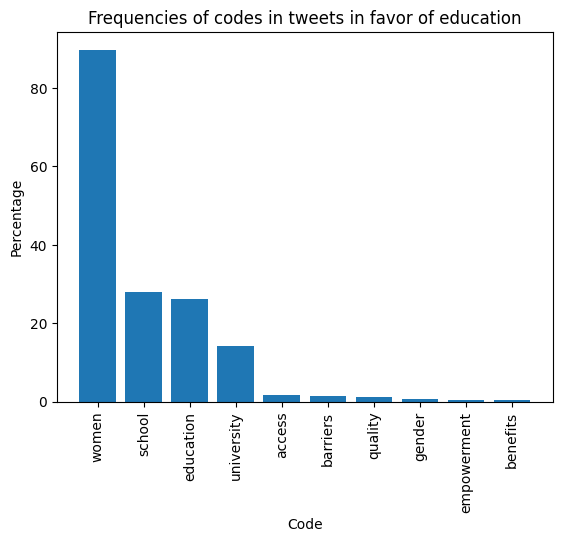

In [19]:
df_codes = df_edu.explode('codes')
# Calculate the frequency and percentage of each code
code_freq = df_codes['codes'].value_counts()
code_perc = code_freq / len(df_edu) * 100
# Plot the code frequencies as a bar chart
plt.bar(code_perc.index, code_perc.values)
plt.title('Frequencies of codes in tweets in favor of education')
plt.xlabel('Code')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.show()

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
for keyword in ['women', 'education', 'school', 'university', 'girl']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())


Sentiment analysis of tweets containing the keyword 'women':
sentiment
negative     530
neutral     1674
positive     901
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'education':
sentiment
negative    229
neutral     639
positive    663
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'school':
sentiment
negative    355
neutral     656
positive    375
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'university':
sentiment
negative    123
neutral     436
positive    210
Name: text, dtype: int64
Sentiment analysis of tweets containing the keyword 'girl':
sentiment
negative     516
neutral     1103
positive     731
Name: text, dtype: int64


In [21]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(keyword_tweets.groupby('sentiment')['text'].count())

Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative     8
neutral     52
positive    28
Name: text, dtype: int64


In [22]:
for keyword in ['women education']:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)].copy()
    keyword_tweets.loc[:, 'sentiment_score'] = keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    sentiment_counts = keyword_tweets.groupby('sentiment')['text'].count()
    total_count = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total_count) * 100
    result = sentiment_counts.astype(str) + ' (' + sentiment_percentages.round(1).astype(str) + '%)'
    print(f"Sentiment analysis of tweets containing the keyword '{keyword}':")
    print(result)


Sentiment analysis of tweets containing the keyword 'women education':
sentiment
negative      8 (9.1%)
neutral     52 (59.1%)
positive    28 (31.8%)
Name: text, dtype: object


##### Average sentiment

In [23]:
import random
from textblob import TextBlob
keywords = ['women education']
all_tweets = [row['text'] for _, row in df.iterrows() if any(keyword in row['text'] for keyword in keywords)]
sample_tweets = random.sample(all_tweets, k=min(10, len(all_tweets)))
mean_sentiment = sum(TextBlob(tweet).sentiment.polarity for tweet in all_tweets) / len(all_tweets) if all_tweets else 0
print(f"Average sentiment score for all tweets: {mean_sentiment}")


Average sentiment score for all tweets: 0.050844278827233386


##### Sentiment Category

In [24]:
import numpy as np
category_sentiment = df_edu.groupby(df_edu['codes'].apply(tuple))['text'].apply(lambda x: np.mean([TextBlob(tweet).sentiment.polarity for tweet in x]))
print("Sentiment Scores by Category:")
category_sentiment.head()

Sentiment Scores by Category:


codes
(education,)              0.062744
(education, access)       0.041667
(education, barriers)     0.000000
(education, benefits)     0.095739
(education, education)    0.098434
Name: text, dtype: float64

##### Calculate the sentiment scores for all tweets

In [40]:
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df['text']]
# Compare the sentiment distributions using a t-test
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment Men:")
print("T-statistic:", t_stat)
print("P-value:", p_value)


Comparison of Sentiment Men:
T-statistic: 13.583254452458187
P-value: 8.2248747478599e-42


In [42]:
men_education_tweets = df[df['text'].str.contains('women education', case=False)]
sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in men_education_tweets['text']]
t_stat, p_value = stats.ttest_1samp(sentiment_scores, 0)
print("Comparison of Sentiment for Women Education Tweets:")
print("T-statistic:", t_stat)
print("P-value:", p_value)

Comparison of Sentiment for Women Education Tweets:
T-statistic: 2.5953068802040136
P-value: 0.011091143507551329


#### Calculate the sentiment scores for tweets containing each keyword

In [27]:
keyword_sentiment = {}
for keyword in keywords:
    keyword_tweets = df_edu[df_edu['text'].str.contains(keyword)]
    sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in keyword_tweets['text']]
    keyword_sentiment[keyword] = np.mean(sentiment_scores)
print("Sentiment Scores by Keyword:")
for keyword, sentiment_score in keyword_sentiment.items():
    print(f"{keyword}: {sentiment_score}")


Sentiment Scores by Keyword:
women education: 0.05084427882723337


##### Chi-square test of independence

In [28]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['gender'], df['label'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print("Chi-square Test of Independence:")
print("Chi-square:", chi2)
print("P-value:", p_value)

Chi-square Test of Independence:
Chi-square: 0.0
P-value: 1.0


##### Create a cross-tabulation between sentiment and gender

In [29]:
cross_tab = pd.crosstab(df['sentiment'], df['gender'])
# Print the cross-tabulation
print("Cross-Tabulation of Sentiment and Gender:")
print(cross_tab)

Cross-Tabulation of Sentiment and Gender:
gender     male
sentiment      
negative   3913
neutral    8307
positive   5180


In [30]:
cross_tab = pd.crosstab(df['gender'], df['label'])
# Print the cross-tabulation
print("Cross-Tabulation of Gender and Label:")
print(cross_tab)

Cross-Tabulation of Gender and Label:
label       0     1
gender             
male    10929  6471


##### Calculate descriptive statistics for women


In [31]:
men_sentiment_scores = [TextBlob(tweet).sentiment.polarity for tweet in df[df['gender'] == 'male']['text']]
# Calculate descriptive statistics for men
men_mean_sentiment = np.mean(men_sentiment_scores)
men_median_sentiment = np.median(men_sentiment_scores)
men_std_sentiment = np.std(men_sentiment_scores)
men_quartiles_sentiment = np.percentile(men_sentiment_scores, [25, 50, 75])

print("Descriptive Statistics for Men:")
print("Mean Sentiment:", men_mean_sentiment)
print("Median Sentiment:", men_median_sentiment)
print("Standard Deviation of Sentiment:", men_std_sentiment)
print("Quartiles of Sentiment:", men_quartiles_sentiment)

Descriptive Statistics for Men:
Mean Sentiment: 0.02428336786358749
Median Sentiment: 0.0
Standard Deviation of Sentiment: 0.23581271943387186
Quartiles of Sentiment: [0.         0.         0.08333333]


##### Frequent Words

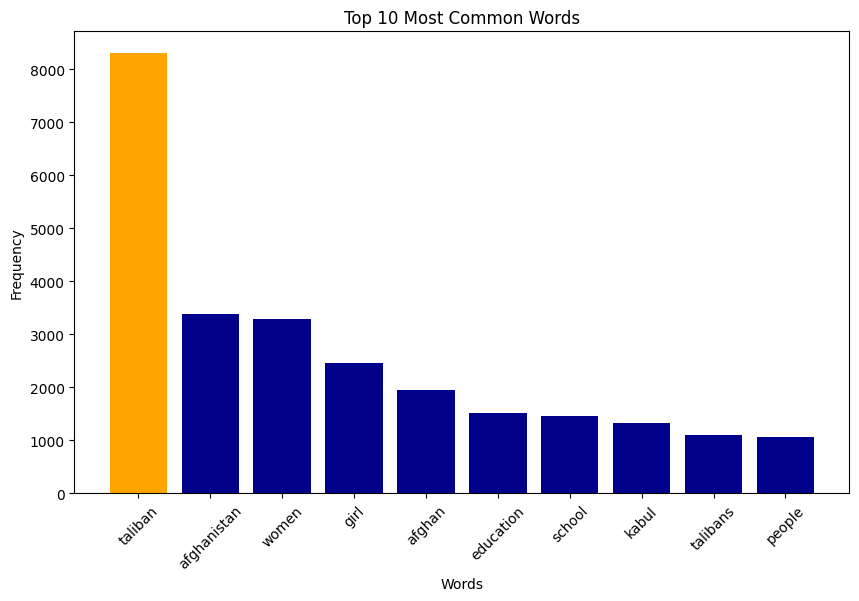

taliban: 8296
afghanistan: 3386
women: 3296
girl: 2461
afghan: 1948
education: 1509
school: 1466
kabul: 1324
talibans: 1103
people: 1059


In [32]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart for the most common words
ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the chart
plt.show()


# Print the most common words and their frequencies
for word, count in most_common_words:
    print(f'{word}: {count}')


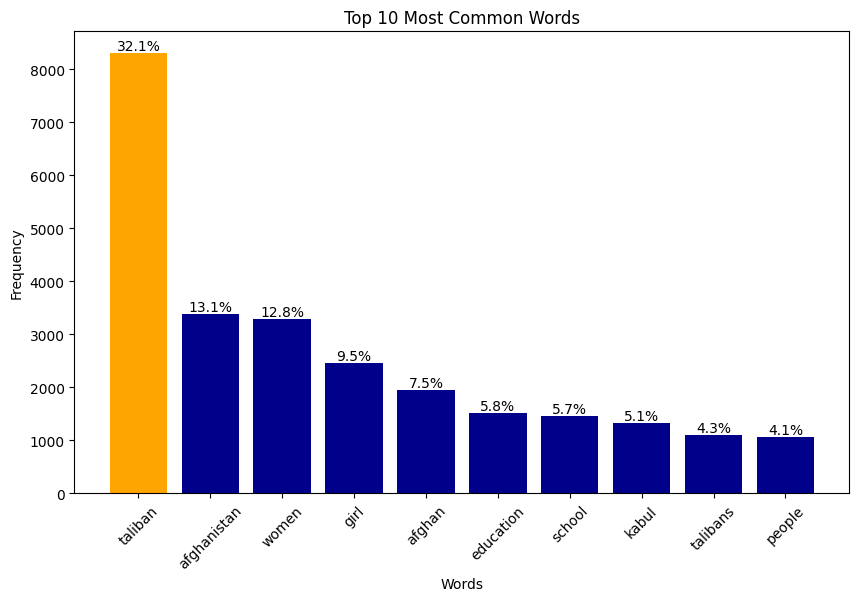

In [33]:
import matplotlib.pyplot as plt
from collections import Counter

# Combine all the text into a single string
all_text = ' '.join(df['text'].tolist())

# Split the text into individual words
all_words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(all_words)

# Retrieve the most common words
most_common_words = word_counts.most_common(10)

# Extract the words and their frequencies
words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

# Calculate the total frequency of all words
total_frequency = sum(frequencies)

# Calculate the percentages
percentages = [count / total_frequency * 100 for count in frequencies]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart for the most common words
bars = ax.bar(words, frequencies, color=['orange', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue'])

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Most Common Words')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add percentage labels above each bar
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom')

# Show the chart
plt.show()


##### Time Series

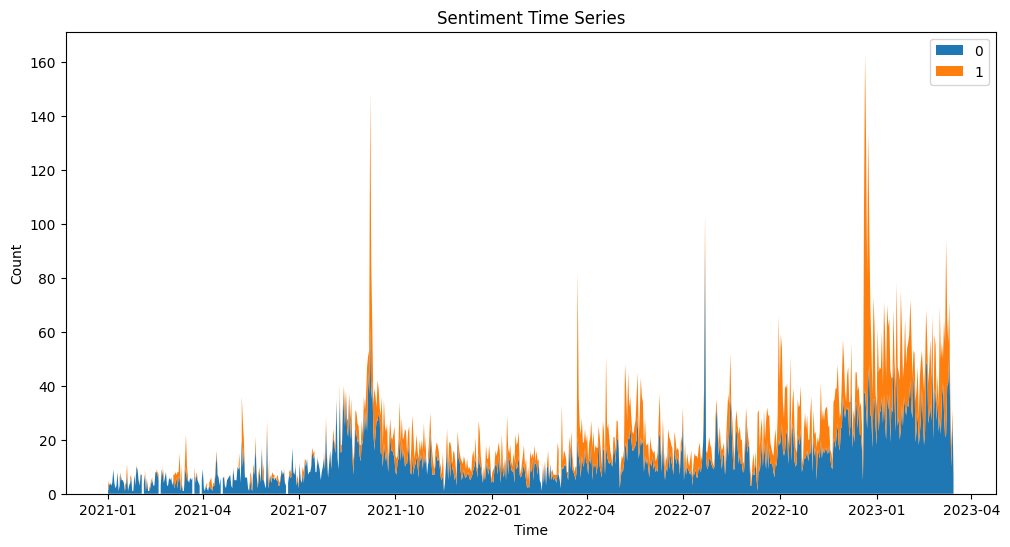

In [34]:

sentiment_counts = df.groupby(['created_at', 'label']).size().unstack()
# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(sentiment_counts.index)
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the stacked area plot for sentiment categories
ax.stackplot(time_periods, sentiment_counts.T, labels=sentiment_counts.columns)
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Sentiment Time Series')
# Add legend
ax.legend()
# Show the chart
plt.show()

##### Frequent Tweet

In [35]:
# Group the data by user name and count the number of tweets
user_tweet_counts = df.groupby('name').size().reset_index(name='tweet_count')

# Sort the user_tweet_counts DataFrame by tweet_count in descending order
user_tweet_counts = user_tweet_counts.sort_values(by='tweet_count', ascending=False)

# Print the top 10 users with the highest tweet counts
print(user_tweet_counts.head(10))


              name  tweet_count
5        HizbkKhan         1352
38  natiqmalikzada         1321
2    Azadi_English         1098
27        ZDaryabi          863
20    OmarHaidari1          794
14     LNajafizada          763
15     MajeedQarar          709
37   matiullahwesa          686
32     bashirgwakh          647
39       naweednow          646


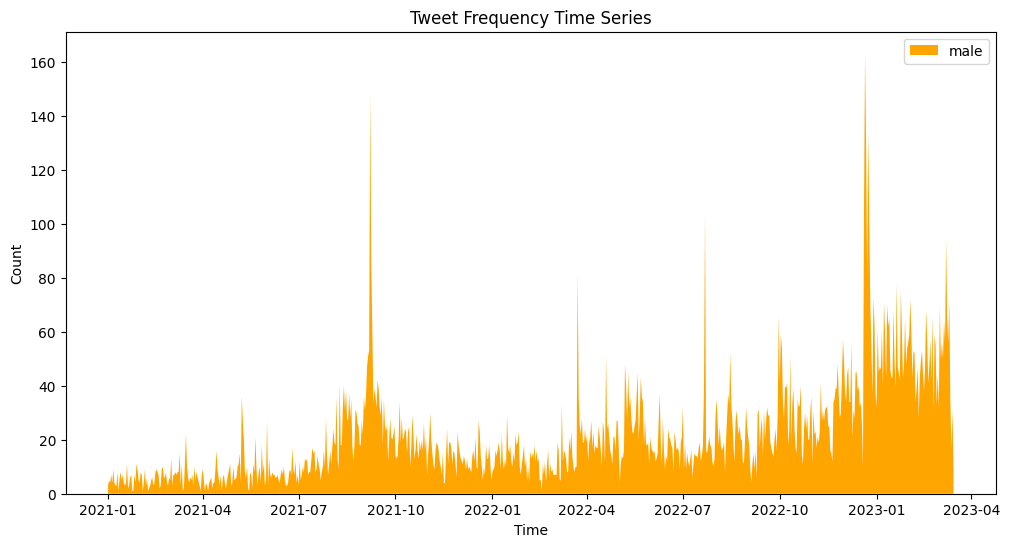

In [36]:
# Group the data by 'created_at' and 'gender', and count the number of tweets for each gender
freq_counts = df.groupby(['created_at', 'gender']).size().unstack()

# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(freq_counts.index)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the stacked area plot for genders
ax.stackplot(time_periods, freq_counts.T, labels=freq_counts.columns, colors=['orange', 'darkblue'])

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Tweet Frequency Time Series')

# Add legend
ax.legend()

# Show the chart
plt.show()


In [37]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
# Create a WordCloud object with customized options
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
# Add a central word
wordcloud.generate_from_text("Afghanistan")
# Manipulate font sizes for the central word and other words
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, contour_width=3, contour_color='steelblue',
                      prefer_horizontal=0.8, relative_scaling=0.5,
                      collocations=False).generate(text)
wordcloud.words_["Afghanistan"] = 80  # Set font size for the central word
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
df.shape

(17408, 8)

In [ ]:
df[['text']].sample(10)

,text
7291,memory aziz badakhsh soldier whose wish end war marry love taliban buried azos together
9731,wake morning pray study prayer work tea
10201,sharifullah resident kunar province national security employee previous regime kicked house kharlaban two days ago
5986,taliban helmand afghanistan banned journalists producing video reports according nai orga
17014,taliban lobbyists warn closing university bad harm islamic system emirate
6370,taliban baghlan province ordered closure women hair salons warned shopkeepers rent sp
3469,gone orban school sovereignty clown zelensky behest
15779,youre right thought much desired taliban rule much suffering
14224,afghan women around world sharing images wearing traditional clothing hashtag donottouchmyc
4361,taliban closes university women taliban lobbyists hear us paid promot


In [ ]:
df.to_excel('../data_processed/men_activists.xlsx', index=False)